## Элементарные методы анализа временных рядов

1.   Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2.   Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline

#### Стационарный ВР:

In [40]:
def train_test_split_time_series(series, train_size=0.7):
    split_index = int(len(series) * train_size)
    train = series[:split_index]
    test = series[split_index:]
    return train, test

def exponential_moving_average(series, alpha, start=None):
    if start is None:
        result = [series.iloc[0]]
    else:
        result = [start]
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
    return pd.Series(result, index=series.index)

In [41]:
births = pd.read_csv("daily-total-female-births-in-cal.csv")["Count"]

b_train, b_test = train_test_split_time_series(births, train_size=0.7)

ema_train = exponential_moving_average(b_train, 0.7)

start_value = ema_train.iloc[-1]
ema_test = exponential_moving_average(b_test, 0.7, start=start_value)

b_rmse = np.sqrt(mean_squared_error(b_test, ema_test))
print(f"RMSE: {b_rmse:.2f}")

RMSE: 2.39


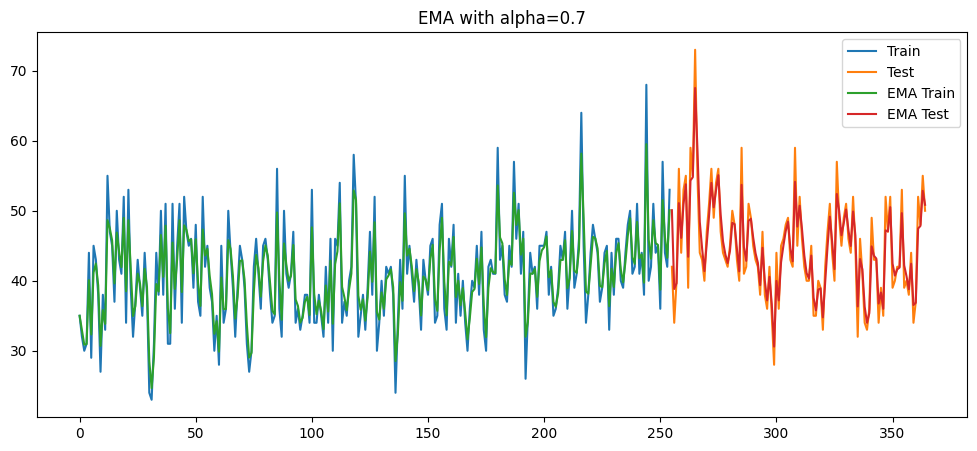

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(b_train.index, b_train, label='Train')
plt.plot(b_test.index, b_test, label='Test')
plt.plot(b_train.index, ema_train, label='EMA Train')
plt.plot(b_test.index, ema_test, label='EMA Test')
plt.legend()
plt.title('EMA with alpha=0.7')
plt.show()

Обоснование:
- использовала EMA, поскольку ряд стационарен, не имеет ни тренда, ни сезонности, но имеет выбросы

#### Нестационарный ВР:

In [45]:
air = pd.read_csv("international-airline-passengers.csv")["Count"]

In [49]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lag', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(air)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
Lag                             13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i]) / season_len
    return sum / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [74]:
train, test = train_test_split_time_series(air, train_size=0.7)

season_len = 12
alpha = 0.6
beta = 0.1
gamma = 0.3

forecast = triple_exponential_smoothing(train.tolist(), season_len, alpha, beta, gamma, n_preds=len(test))

forecast_test = forecast[-len(test):]

rmse = np.sqrt(mean_squared_error(test, forecast_test))
print(f"Holt-Winters RMSE: {rmse:.2f}")

Holt-Winters RMSE: 44.37


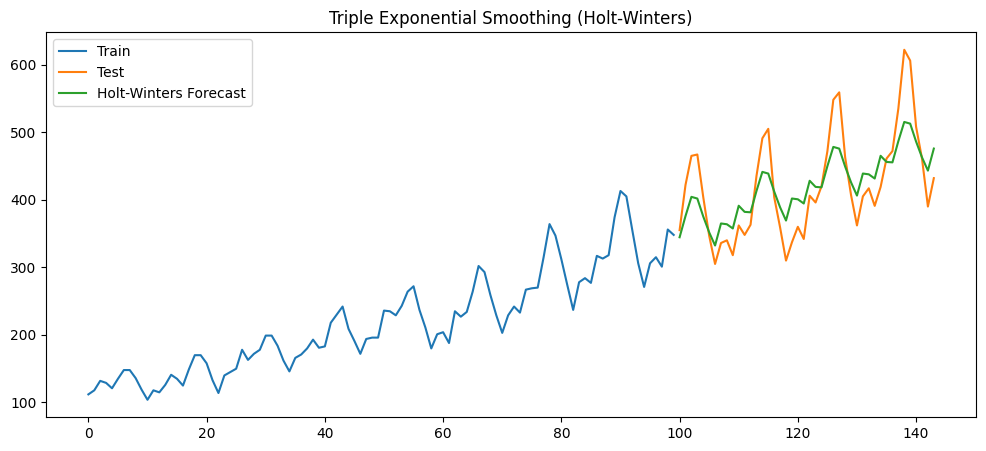

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_test, label='Holt-Winters Forecast')
plt.legend()
plt.title('Triple Exponential Smoothing (Holt-Winters)')
plt.show()

Обоснование:
- использовала TEMA, поскольку ряд не стационарен, имеет тренд и сезонность